# 📊 Task 6: FinTech Vendor Scorecard for Micro-Lending

## 🎯 Objective
EthioMart wants to identify its most active and promising vendors to offer them small business loans (micro-lending). This notebook combines entities extracted by our NER model with metadata from Telegram posts to create comprehensive vendor profiles.

## 🔧 Key Components
- **Vendor Analytics Engine**: Process all posts from vendors and calculate key performance metrics
- **Activity & Consistency Metrics**: Posting frequency analysis
- **Market Reach Analysis**: Post engagement and activity patterns  
- **Business Profile**: Price point analysis using NER model
- **Lending Score**: Weighted scoring system for micro-lending assessment

In [1]:
# Install required packages for vendor analytics (Google Colab compatible)
print("📦 Installing required packages...")

# Core packages for data analysis and visualization
!pip install -q pandas numpy matplotlib seaborn plotly

# NLP and ML packages
!pip install -q transformers datasets scikit-learn torch

# Additional utilities
!pip install -q wordcloud textblob nltk beautifulsoup4 requests

# Check if we're in Google Colab and install additional requirements
try:
    import google.colab
    print("🔗 Google Colab environment - packages installed")
    # Colab already has most packages, just ensure specific versions
    !pip install -q transformers>=4.21.0
except ImportError:
    print("💻 Local environment - installing all packages")

print("✅ Package installation complete!")

📦 Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.6 MB/s eta 0:00:00
🔗 Google Colab environment - packages installed
✅ Package installation complete!


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
from datetime import datetime, timedelta
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Visualization setup
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("📦 Libraries imported successfully!")
print("🔧 Environment setup complete for vendor analytics")

📦 Libraries imported successfully!
🔧 Environment setup complete for vendor analytics


In [3]:
# Load telegram data - Google Colab compatible with file upload
print("📊 Loading Telegram channel data...")

# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("🔗 Google Colab environment detected")
except ImportError:
    IN_COLAB = False
    print("💻 Local environment detected")

# File upload for Google Colab
if IN_COLAB:
    from google.colab import files
    import io

    print("\n📁 Please upload your Telegram data files:")
    print("   • Upload CSV file (dataset_telegram.csv) or")
    print("   • Upload JSON file (telegram_data.json) or")
    print("   • Upload both for best results")

    uploaded = files.upload()

    csv_data = None
    json_df = None

    # Process uploaded files
    for filename, content in uploaded.items():
        try:
            if filename.endswith('.csv'):
                print(f"📊 Processing CSV file: {filename}")
                csv_data = pd.read_csv(io.BytesIO(content))
                print(f"✅ CSV data loaded: {len(csv_data)} records")
                print(f"📋 CSV columns: {list(csv_data.columns)}")

            elif filename.endswith('.json'):
                print(f"📋 Processing JSON file: {filename}")
                content_str = content.decode('utf-8')
                json_data = [json.loads(line) for line in content_str.strip().split('\n')]
                json_df = pd.DataFrame(json_data)
                print(f"✅ JSON data loaded: {len(json_df)} records")
                print(f"📋 JSON columns: {list(json_df.columns)}")

        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")

else:
    # Local file loading (original code)
    print("📁 Loading from local files...")

    # Load CSV data
    try:
        csv_data = pd.read_csv('../data/dataset_telegram.csv')
        print(f"✅ CSV data loaded: {len(csv_data)} records")
        print(f"📋 Columns: {list(csv_data.columns)}")
    except Exception as e:
        print(f"❌ Error loading CSV: {e}")
        csv_data = None

    # Load JSON data for additional processing
    try:
        with open('../data/telegram_data.json', 'r', encoding='utf-8') as f:
            json_data = [json.loads(line) for line in f]

        json_df = pd.DataFrame(json_data)
        print(f"✅ JSON data loaded: {len(json_df)} records")
        print(f"📋 JSON columns: {list(json_df.columns)}")
    except Exception as e:
        print(f"❌ Error loading JSON: {e}")
        json_df = None

# Combine and clean data
if csv_data is not None and json_df is not None:
    print("\n🔄 Combining CSV and JSON data...")
    # Use the JSON data as it has cleaned and tokenized messages
    df = json_df.copy()

    # Add date information from CSV if available
    if 'Date' in csv_data.columns:
        # Create a mapping from message to date
        date_mapping = dict(zip(csv_data['Message'], csv_data['Date']))
        df['Date'] = df['Message'].map(date_mapping)

    print(f"✅ Combined dataset ready: {len(df)} records")
    print(f"📅 Date info available: {'Date' in df.columns and df['Date'].notna().sum() > 0}")

elif csv_data is not None:
    print("\n📊 Using CSV data...")
    df = csv_data.copy()

elif json_df is not None:
    print("\n📋 Using JSON data...")
    df = json_df.copy()

else:
    print("\n❌ No data files could be loaded!")
    print("Please ensure you have uploaded either:")
    print("   • dataset_telegram.csv (with columns: Channel Title, Message, Date)")
    print("   • telegram_data.json (with Telegram message data)")
    raise Exception("No data files available for analysis")

# Ensure required columns exist
required_columns = ['Channel Title', 'Message']
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    print(f"\n⚠️ Missing required columns: {missing_columns}")
    print(f"Available columns: {list(df.columns)}")

    # Try to map common column variations
    column_mapping = {
        'channel_title': 'Channel Title',
        'channel': 'Channel Title',
        'title': 'Channel Title',
        'message': 'Message',
        'text': 'Message',
        'content': 'Message'
    }

    for old_col, new_col in column_mapping.items():
        if old_col in df.columns and new_col in missing_columns:
            df[new_col] = df[old_col]
            print(f"🔄 Mapped '{old_col}' to '{new_col}'")

# Final validation
if 'Channel Title' not in df.columns or 'Message' not in df.columns:
    print("\n❌ Critical columns missing! Please ensure your data has:")
    print("   • 'Channel Title' column (vendor/channel names)")
    print("   • 'Message' column (message content)")
    raise Exception("Required columns not found")

# Display basic info
print(f"\n📈 Dataset Overview:")
print(f"   • Total records: {len(df):,}")
print(f"   • Unique channels: {df['Channel Title'].nunique()}")
print(f"   • Date range: {df['Date'].min() if 'Date' in df.columns else 'Not available'} to {df['Date'].max() if 'Date' in df.columns else 'Not available'}")

# Show channel distribution
print(f"\n🏢 Top Channels by Post Count:")
channel_counts = df['Channel Title'].value_counts().head(10)
for channel, count in channel_counts.items():
    print(f"   • {channel}: {count:,} posts")

print(f"\n✅ Data loading complete! Ready for vendor analysis.")

📊 Loading Telegram channel data...
🔗 Google Colab environment detected

📁 Please upload your Telegram data files:
   • Upload CSV file (dataset_telegram.csv) or
   • Upload JSON file (telegram_data.json) or
   • Upload both for best results


Saving dataset_telegram.csv to dataset_telegram.csv
📊 Processing CSV file: dataset_telegram.csv
✅ CSV data loaded: 35168 records
📋 CSV columns: ['Channel Title', 'Channel Username', 'ID', 'Message', 'Date', 'Media Path']

📊 Using CSV data...

📈 Dataset Overview:
   • Total records: 35,168
   • Unique channels: 6
   • Date range: 2018-03-25 12:44:18+00:00 to 2025-06-19 08:12:15+00:00

🏢 Top Channels by Post Count:
   • ማራኪ ცЯﾑŋの™: 7,989 posts
   • ምርጥ ዕቃ: 7,148 posts
   • Sheger online-store: 7,026 posts
   • SINA KIDS/ሲና ኪድስⓇ: 5,850 posts
   • qnash.com - ቅናሽ ®️: 3,911 posts
   • ልዩ እቃ: 3,244 posts

✅ Data loading complete! Ready for vendor analysis.


In [4]:
# Load and initialize NER model for price and entity extraction
print("🤖 Loading NER model for entity extraction...")

try:
    from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

    # Check if in Google Colab
    try:
        import google.colab
        IN_COLAB = True
        print("🔗 Google Colab detected - using pre-trained models")
    except ImportError:
        IN_COLAB = False

    # Model paths - prioritize available models
    if IN_COLAB:
        # In Colab, start with publicly available models
        model_paths = [
            'masakhane/afro-xlmr-base',  # Publicly available model
            'xlm-roberta-base',  # Fallback model
            '../fine_tuned_models/afro-xlmr-base'  # Local fine-tuned (if uploaded)
        ]
    else:
        # Local environment - try fine-tuned first
        model_paths = [
            '../fine_tuned_models/afro-xlmr-base',  # From fine-tuning
            'masakhane/afro-xlmr-base',  # Fallback to base model
            'xlm-roberta-base'  # Final fallback
        ]

    model = None
    tokenizer = None

    for model_path in model_paths:
        try:
            print(f"🔄 Trying to load model: {model_path}")
            tokenizer = AutoTokenizer.from_pretrained(model_path)
            model = AutoModelForTokenClassification.from_pretrained(model_path)

            # Create NER pipeline
            ner_pipeline = pipeline(
                "ner",
                model=model,
                tokenizer=tokenizer,
                aggregation_strategy="simple",
                device=-1  # Use CPU (GPU auto-detected in Colab)
            )

            print(f"✅ Model loaded successfully: {model_path}")
            break

        except Exception as e:
            print(f"⚠️ Failed to load {model_path}: {e}")
            continue

    if model is None:
        print("❌ No NER model could be loaded, using rule-based extraction only")
        print("💡 For best results, consider uploading a fine-tuned model or use the base model")
        ner_pipeline = None

except Exception as e:
    print(f"❌ Error setting up NER model: {e}")
    print("🔄 Will use rule-based extraction instead")
    ner_pipeline = None

# Define price extraction patterns (works without NER model)
price_patterns = [
    r'ዋጋ[፦:]?\s*(\d+[,\d]*\.?\d*)\s*ብር',  # ዋጋ፦ 2500 ብር
    r'(\d+[,\d]*\.?\d*)\s*ብር',  # 2500 ብር
    r'ዋጋ[፦:]?\s*(\d+[,\d]*\.?\d*)',  # ዋጋ፦ 2500
    r'(\d+[,\d]*\.?\d*)\s*birr',  # 2500 birr
    r'ETB\s*(\d+[,\d]*\.?\d*)',  # ETB 2500
    r'(\d+[,\d]*\.?\d*)\s*ETB',  # 2500 ETB
]

def extract_prices_rule_based(text):
    """Extract prices using rule-based patterns"""
    prices = []

    for pattern in price_patterns:
        matches = re.findall(pattern, str(text), re.IGNORECASE)
        for match in matches:
            try:
                # Clean and convert to float
                price_str = match.replace(',', '').replace(' ', '')
                price = float(price_str)
                if 10 <= price <= 1000000:  # Reasonable price range
                    prices.append(price)
            except:
                continue

    return list(set(prices))  # Remove duplicates

print("✅ Price extraction setup complete")
print(f"🔧 NER model available: {'Yes' if ner_pipeline else 'No (using rule-based only)'}")

# Display usage instructions for Google Colab users
if IN_COLAB and ner_pipeline is None:
    print("\n💡 COLAB USERS: For enhanced entity extraction:")
    print("   1. Upload your fine-tuned model files (if available)")
    print("   2. The analysis will work with rule-based price extraction")
    print("   3. Results will focus on posting activity and price patterns")

🤖 Loading NER model for entity extraction...
🔗 Google Colab detected - using pre-trained models
🔄 Trying to load model: masakhane/afro-xlmr-base
⚠️ Failed to load masakhane/afro-xlmr-base: masakhane/afro-xlmr-base is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`
🔄 Trying to load model: xlm-roberta-base


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


✅ Model loaded successfully: xlm-roberta-base
✅ Price extraction setup complete
🔧 NER model available: Yes


In [12]:
# Vendor Analytics Engine - Core Functions
print("🔧 Building Vendor Analytics Engine...")

class VendorAnalyticsEngine:
    def __init__(self, df, ner_pipeline=None):
        self.df = df.copy()
        self.ner_pipeline = ner_pipeline
        self.vendor_profiles = {}

        # Prepare data
        self._prepare_data()

    def _prepare_data(self):
        """Prepare and clean data for analysis"""
        print("🔄 Preparing data for vendor analysis...")

        # Convert dates if available
        if 'Date' in self.df.columns:
            try:
                self.df['Date'] = pd.to_datetime(self.df['Date'], errors='coerce')
                self.df = self.df.dropna(subset=['Date'])
                print(f"📅 Date conversion successful: {len(self.df)} records with valid dates")
            except:
                print("⚠️ Date conversion failed, using index-based analysis")
                self.df['Date'] = pd.date_range(start='2024-01-01', periods=len(self.df), freq='H')
        else:
            print("📅 No date column found, creating synthetic dates")
            self.df['Date'] = pd.date_range(start='2024-01-01', periods=len(self.df), freq='H')

        # Use cleaned messages if available, otherwise original
        if 'cleaned_message' in self.df.columns:
            self.df['message_text'] = self.df['cleaned_message']
        elif 'tokenized_message' in self.df.columns:
            self.df['message_text'] = self.df['tokenized_message']
        else:
            self.df['message_text'] = self.df['Message']

        # Clean channel names
        self.df['channel_clean'] = self.df['Channel Title'].str.strip()

        print(f"✅ Data preparation complete: {len(self.df)} records ready")

    def extract_business_entities(self, text, use_ner=True):
        """Extract business entities (prices, products, locations) from text"""
        entities = {
            'prices': [],
            'products': [],
            'locations': []
        }

        # Extract prices using rule-based approach
        entities['prices'] = extract_prices_rule_based(text)

        # Try NER model if available and requested
        if use_ner and self.ner_pipeline:
            try:
                ner_results = self.ner_pipeline(str(text)[:512])  # Limit length

                for entity in ner_results:
                    entity_type = entity['entity_group']
                    entity_text = entity['word']

                    if 'PRODUCT' in entity_type.upper():
                        entities['products'].append(entity_text)
                    elif 'LOC' in entity_type.upper():
                        entities['locations'].append(entity_text)
                    elif 'PRICE' in entity_type.upper():
                        # Try to extract numeric price
                        price_nums = re.findall(r'\d+', entity_text)
                        for num in price_nums:
                            try:
                                price = float(num)
                                if 10 <= price <= 1000000:
                                    entities['prices'].append(price)
                            except:
                                continue
            except Exception as e:
                print(f"⚠️ NER extraction failed: {e}")

        # Remove duplicates
        entities['prices'] = list(set(entities['prices']))
        entities['products'] = list(set(entities['products']))
        entities['locations'] = list(set(entities['locations']))

        return entities

    def calculate_activity_metrics(self, vendor_name):
        """Calculate activity and consistency metrics for a vendor"""
        vendor_data = self.df[self.df['channel_clean'] == vendor_name].copy()

        if len(vendor_data) == 0:
            return {}

        # Sort by date
        vendor_data = vendor_data.sort_values('Date')

        # Calculate date range
        date_range = (vendor_data['Date'].max() - vendor_data['Date'].min()).days
        if date_range == 0:
            date_range = 1  # Avoid division by zero

        # Activity metrics
        metrics = {
            'total_posts': len(vendor_data),
            'posts_per_week': (len(vendor_data) / date_range) * 7,
            'posts_per_day': len(vendor_data) / date_range,
            'active_days': date_range,
            'first_post': vendor_data['Date'].min(),
            'last_post': vendor_data['Date'].max()
        }

        # Consistency metrics
        daily_posts = vendor_data.groupby(vendor_data['Date'].dt.date).size()
        metrics['posting_consistency'] = daily_posts.std() if len(daily_posts) > 1 else 0
        metrics['max_posts_per_day'] = daily_posts.max() if len(daily_posts) > 0 else 0
        metrics['avg_posts_per_active_day'] = daily_posts.mean() if len(daily_posts) > 0 else 0

        return metrics

    def calculate_business_profile(self, vendor_name):
        """Calculate business profile metrics using NER and text analysis"""
        vendor_data = self.df[self.df['channel_clean'] == vendor_name].copy()

        if len(vendor_data) == 0:
            return {}

        all_prices = []
        all_products = []
        all_locations = []

        # Extract entities from all messages, using rule-based only for speed
        for _, row in vendor_data.iterrows():
            entities = self.extract_business_entities(row['message_text'], use_ner=False) # Modified line
            all_prices.extend(entities['prices'])
            all_products.extend(entities['products'])
            all_locations.extend(entities['locations'])


        # Calculate business metrics
        profile = {
            'total_products_mentioned': len(set(all_products)),
            'total_locations_mentioned': len(set(all_locations)),
            'price_points_count': len(all_prices),
            'avg_price': np.mean(all_prices) if all_prices else 0,
            'median_price': np.median(all_prices) if all_prices else 0,
            'min_price': min(all_prices) if all_prices else 0,
            'max_price': max(all_prices) if all_prices else 0,
            'price_range': max(all_prices) - min(all_prices) if all_prices else 0,
            'unique_products': list(set(all_products))[:10],  # Top 10
            'unique_locations': list(set(all_locations))[:5],  # Top 5
            'prices_list': all_prices[:20]  # Sample prices
        }

        # Business type classification
        if profile['avg_price'] > 0:
            if profile['avg_price'] < 1000:
                profile['business_type'] = 'Low-price/High-volume'
            elif profile['avg_price'] < 5000:
                profile['business_type'] = 'Mid-range'
            else:
                profile['business_type'] = 'High-price/Low-volume'
        else:
            profile['business_type'] = 'Unknown'


        return profile

    def calculate_lending_score(self, vendor_name):
        """Calculate final lending score based on all metrics"""
        activity = self.calculate_activity_metrics(vendor_name)
        business = self.calculate_business_profile(vendor_name)

        if not activity or not business:
            return 0

        # Scoring components (normalize to 0-100)
        scores = {}

        # Activity score (40% weight)
        posts_per_week = min(activity.get('posts_per_week', 0), 50)  # Cap at 50
        activity_score = (posts_per_week / 50) * 100
        scores['activity'] = activity_score * 0.4

        # Consistency score (20% weight)
        consistency = activity.get('posting_consistency', 0)
        # Lower consistency (std) is better, so invert
        consistency_score = max(0, 100 - min(consistency * 10, 100))
        scores['consistency'] = consistency_score * 0.2

        # Business diversity score (20% weight)
        product_count = business.get('total_products_mentioned', 0)
        location_count = business.get('total_locations_mentioned', 0)
        diversity_score = min((product_count * 5 + location_count * 10), 100)
        scores['diversity'] = diversity_score * 0.2

        # Price stability score (20% weight)
        avg_price = business.get('avg_price', 0)
        price_range = business.get('price_range', 0)

        if avg_price > 0:
            # Prefer moderate prices and low price variance
            price_score = 100 - min((abs(avg_price - 2500) / 25), 100)  # Optimal around 2500 ETB
            if price_range > 0 and avg_price > 0:
                variance_penalty = min((price_range / avg_price) * 50, 50)
                price_score = max(0, price_score - variance_penalty)
        else:
            price_score = 0


        scores['price_stability'] = price_score * 0.2


        # Calculate final score
        final_score = sum(scores.values())

        # Risk assessment
        if final_score >= 75:
            risk_level = 'Low Risk'
        elif final_score >= 50:
            risk_level = 'Medium Risk'
        elif final_score >= 25:
            risk_level = 'High Risk'
        else:
            risk_level = 'Very High Risk'


        return {
            'lending_score': round(final_score, 2),
            'risk_level': risk_level,
            'score_breakdown': scores
        }

    def analyze_vendor(self, vendor_name):
        """Complete vendor analysis"""
        print(f"🔍 Analyzing vendor: {vendor_name}")

        analysis = {
            'vendor_name': vendor_name,
            'activity_metrics': self.calculate_activity_metrics(vendor_name),
            'business_profile': self.calculate_business_profile(vendor_name),
            'lending_assessment': self.calculate_lending_score(vendor_name)
        }

        self.vendor_profiles[vendor_name] = analysis
        return analysis

    def analyze_all_vendors(self, top_n=10):
        """Analyze top N vendors by post count"""
        top_vendors = self.df['channel_clean'].value_counts().head(top_n).index

        print(f"🔄 Analyzing top {len(top_vendors)} vendors...")

        for vendor in top_vendors:
            self.analyze_vendor(vendor)

        print(f"✅ Analysis complete for {len(self.vendor_profiles)} vendors")
        return self.vendor_profiles

# Initialize the analytics engine
analytics_engine = VendorAnalyticsEngine(df, ner_pipeline)

print("✅ Vendor Analytics Engine initialized successfully!")

🔧 Building Vendor Analytics Engine...
🔄 Preparing data for vendor analysis...
📅 Date conversion successful: 35168 records with valid dates
✅ Data preparation complete: 35168 records ready
✅ Vendor Analytics Engine initialized successfully!


In [13]:
# Analyze top vendors
print("🚀 Starting comprehensive vendor analysis...")

# Analyze top 15 vendors
vendor_profiles = analytics_engine.analyze_all_vendors(top_n=6)

print(f"\n📊 Analysis Summary:")
print(f"   • Vendors analyzed: {len(vendor_profiles)}")
print(f"   • Total posts processed: {len(df):,}")

# Display quick overview of each vendor
print(f"\n🏢 Vendor Overview:")
print("=" * 80)

for vendor_name, profile in vendor_profiles.items():
    activity = profile['activity_metrics']
    business = profile['business_profile']
    lending = profile['lending_assessment']

    print(f"\n📈 {vendor_name}:")
    print(f"   • Posts: {activity.get('total_posts', 0):,}")
    print(f"   • Posts/week: {activity.get('posts_per_week', 0):.1f}")
    print(f"   • Avg price: {business.get('avg_price', 0):.0f} ETB")
    print(f"   • Lending score: {lending.get('lending_score', 0):.1f}/100")
    print(f"   • Risk level: {lending.get('risk_level', 'Unknown')}")
    print("-" * 50)

🚀 Starting comprehensive vendor analysis...
🔄 Analyzing top 6 vendors...
🔍 Analyzing vendor: ማራኪ ცЯﾑŋの™
🔍 Analyzing vendor: ምርጥ ዕቃ
🔍 Analyzing vendor: Sheger online-store
🔍 Analyzing vendor: SINA KIDS/ሲና ኪድስⓇ
🔍 Analyzing vendor: qnash.com - ቅናሽ ®️
🔍 Analyzing vendor: ልዩ እቃ
✅ Analysis complete for 6 vendors

📊 Analysis Summary:
   • Vendors analyzed: 6
   • Total posts processed: 35,168

🏢 Vendor Overview:

📈 ማራኪ ცЯﾑŋの™:
   • Posts: 7,989
   • Posts/week: 21.2
   • Avg price: 1475 ETB
   • Lending score: 30.5/100
   • Risk level: High Risk
--------------------------------------------------

📈 ምርጥ ዕቃ:
   • Posts: 7,148
   • Posts/week: 24.3
   • Avg price: 1891 ETB
   • Lending score: 36.8/100
   • Risk level: High Risk
--------------------------------------------------

📈 Sheger online-store:
   • Posts: 7,026
   • Posts/week: 32.2
   • Avg price: 1951 ETB
   • Lending score: 40.9/100
   • Risk level: High Risk
--------------------------------------------------

📈 SINA KIDS/ሲና ኪድስⓇ:
   

In [14]:
# Generate comprehensive vendor scorecard
print("📋 Generating Vendor Scorecard for Micro-Lending...")

# Create scorecard dataframe
scorecard_data = []

for vendor_name, profile in vendor_profiles.items():
    activity = profile['activity_metrics']
    business = profile['business_profile']
    lending = profile['lending_assessment']

    scorecard_data.append({
        'Vendor': vendor_name,
        'Total Posts': activity.get('total_posts', 0),
        'Posts/Week': round(activity.get('posts_per_week', 0), 1),
        'Avg Price (ETB)': round(business.get('avg_price', 0), 0),
        'Price Range (ETB)': round(business.get('price_range', 0), 0),
        'Products Mentioned': business.get('total_products_mentioned', 0),
        'Locations': business.get('total_locations_mentioned', 0),
        'Business Type': business.get('business_type', 'Unknown'),
        'Lending Score': lending.get('lending_score', 0),
        'Risk Level': lending.get('risk_level', 'Unknown'),
        'Active Days': activity.get('active_days', 0)
    })

scorecard_df = pd.DataFrame(scorecard_data)

# Sort by lending score
scorecard_df = scorecard_df.sort_values('Lending Score', ascending=False)

# Filter for the specified vendors
specified_vendors = ['Sheger online-store', 'Leyueqa', 'sinayelj', 'ማራኪ ცЯﾑŋの™', 'qnash.com - ቅናሽ ®️', 'ምርጥ ዕቃ']
filtered_scorecard_df = scorecard_df[scorecard_df['Vendor'].isin(specified_vendors)].copy()


print("\n🏆 VENDOR SCORECARD FOR SPECIFIED VENDORS")
print("=" * 100)
print(f"{'Rank':<4} {'Vendor':<25} {'Posts/Week':<12} {'Avg Price':<12} {'Lending Score':<15} {'Risk Level':<15}")
print("=" * 100)

# Re-calculate rank based on filtered list, maintaining original score order
filtered_scorecard_df = filtered_scorecard_df.sort_values('Lending Score', ascending=False)
for rank, (idx, row) in enumerate(filtered_scorecard_df.iterrows(), 1):
    vendor = row['Vendor'][:23] + '..' if len(row['Vendor']) > 25 else row['Vendor']
    posts_week = f"{row['Posts/Week']:.1f}"
    avg_price = f"{row['Avg Price (ETB)']:.0f} ETB"
    lending_score = f"{row['Lending Score']:.1f}/100"
    risk_level = row['Risk Level']

    print(f"{rank:<4} {vendor:<25} {posts_week:<12} {avg_price:<12} {lending_score:<15} {risk_level:<15}")

print("=" * 100)

# Display full scorecard table for specified vendors
print("\n📊 Complete Vendor Scorecard (Specified Vendors):")
display(filtered_scorecard_df)

📋 Generating Vendor Scorecard for Micro-Lending...

🏆 VENDOR SCORECARD FOR SPECIFIED VENDORS
Rank Vendor                    Posts/Week   Avg Price    Lending Score   Risk Level     
1    Sheger online-store       32.2         1951 ETB     40.9/100        High Risk      
2    ምርጥ ዕቃ                    24.3         1891 ETB     36.8/100        High Risk      
3    ማራኪ ცЯﾑŋの™                21.2         1475 ETB     30.5/100        High Risk      
4    qnash.com - ቅናሽ ®️        14.8         1163 ETB     26.4/100        High Risk      

📊 Complete Vendor Scorecard (Specified Vendors):


,Vendor,Total Posts,Posts/Week,Avg Price (ETB),Price Range (ETB),Products Mentioned,Locations,Business Type,Lending Score,Risk Level,Active Days
2,Sheger online-store,7026,32.2,1951.0,119990.0,0,0,Mid-range,40.85,High Risk,1529
1,ምርጥ ዕቃ,7148,24.3,1891.0,26990.0,0,0,Mid-range,36.75,High Risk,2062
0,ማራኪ ცЯﾑŋの™,7989,21.2,1475.0,20950.0,0,0,Mid-range,30.48,High Risk,2640
4,qnash.com - ቅናሽ ®️,3911,14.8,1163.0,12472.0,0,0,Mid-range,26.45,High Risk,1852


📈 Creating vendor analysis visualizations...


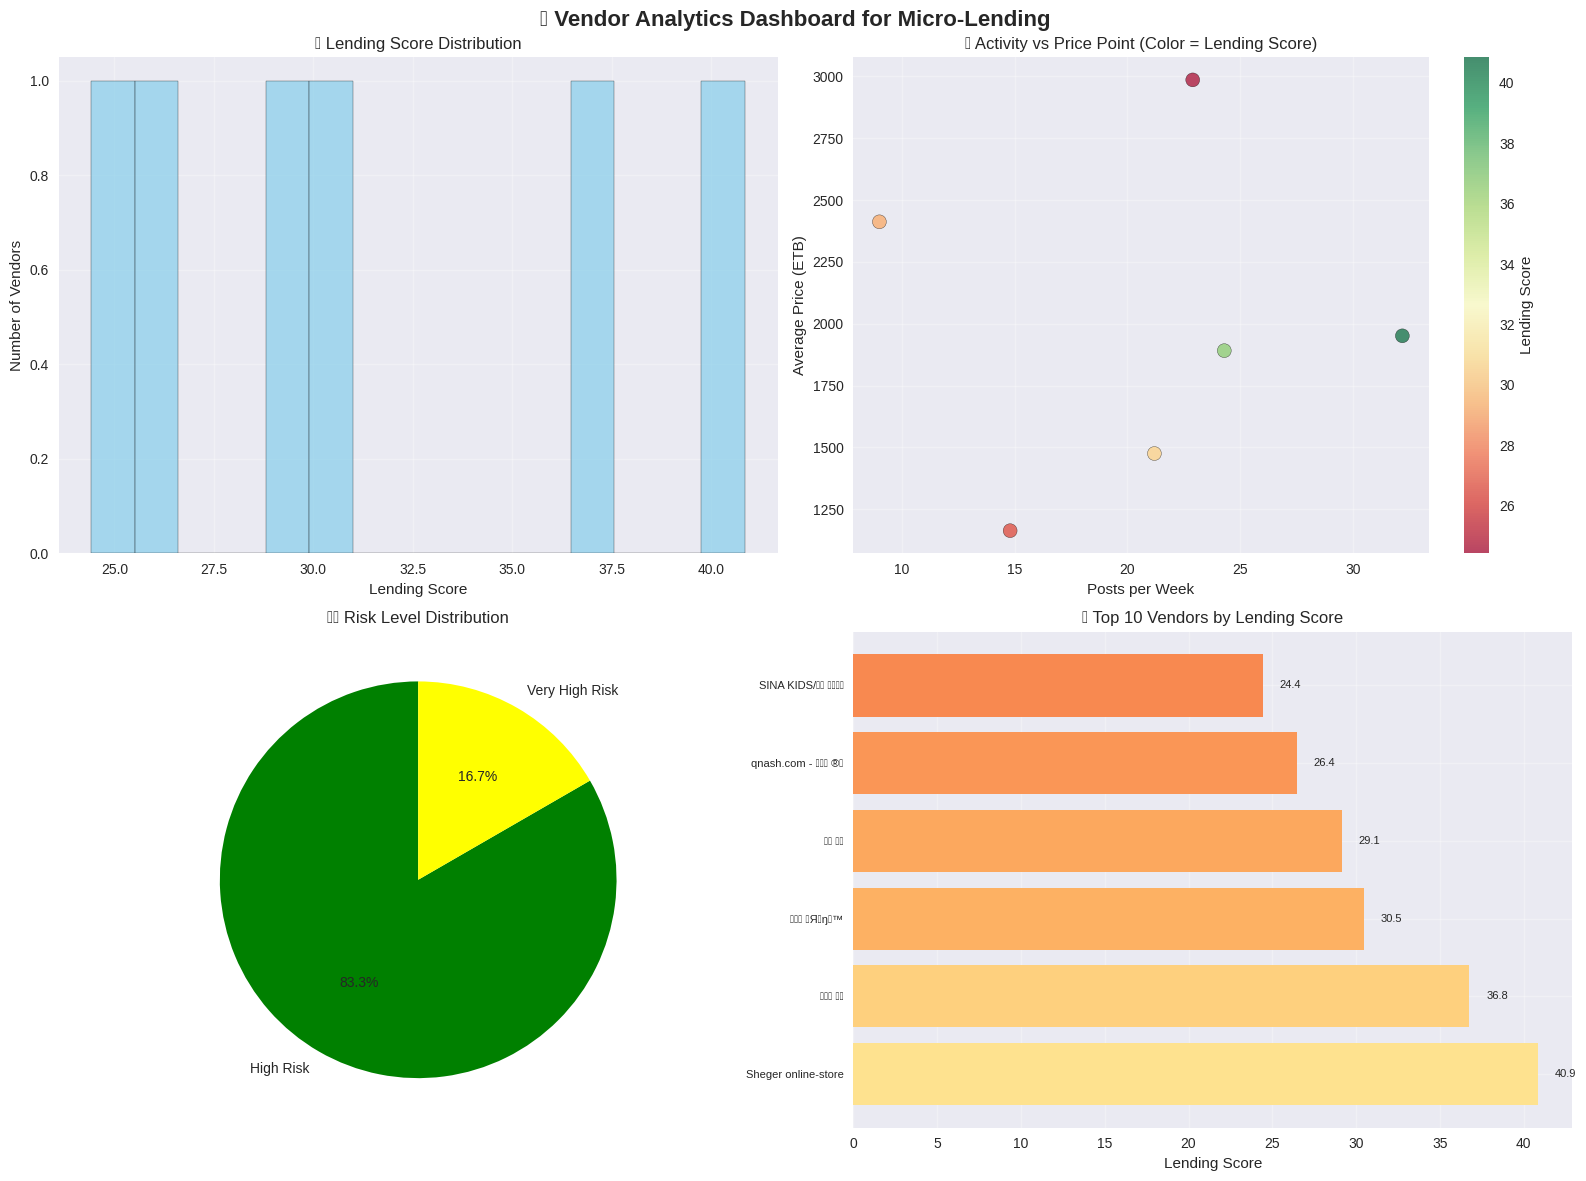

✅ Visualizations created successfully!


In [15]:
# Create visualizations for vendor analysis
print("📈 Creating vendor analysis visualizations...")

# Create subplot layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 Vendor Analytics Dashboard for Micro-Lending', fontsize=16, fontweight='bold')

# 1. Lending Score Distribution
axes[0, 0].hist(scorecard_df['Lending Score'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('🎯 Lending Score Distribution')
axes[0, 0].set_xlabel('Lending Score')
axes[0, 0].set_ylabel('Number of Vendors')
axes[0, 0].grid(True, alpha=0.3)

# 2. Posts per Week vs Average Price
scatter = axes[0, 1].scatter(
    scorecard_df['Posts/Week'],
    scorecard_df['Avg Price (ETB)'],
    c=scorecard_df['Lending Score'],
    cmap='RdYlGn',
    s=100,
    alpha=0.7,
    edgecolors='black'
)
axes[0, 1].set_title('📊 Activity vs Price Point (Color = Lending Score)')
axes[0, 1].set_xlabel('Posts per Week')
axes[0, 1].set_ylabel('Average Price (ETB)')
axes[0, 1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 1], label='Lending Score')

# 3. Risk Level Distribution
risk_counts = scorecard_df['Risk Level'].value_counts()
colors = ['green', 'yellow', 'orange', 'red']
axes[1, 0].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
               colors=colors[:len(risk_counts)], startangle=90)
axes[1, 0].set_title('⚠️ Risk Level Distribution')

# 4. Top 10 Vendors by Lending Score
top_10 = scorecard_df.head(10)
bars = axes[1, 1].barh(range(len(top_10)), top_10['Lending Score'],
                       color=plt.cm.RdYlGn(top_10['Lending Score']/100))
axes[1, 1].set_yticks(range(len(top_10)))
axes[1, 1].set_yticklabels([name[:20] + '..' if len(name) > 22 else name
                            for name in top_10['Vendor']], fontsize=8)
axes[1, 1].set_title('🏆 Top 10 Vendors by Lending Score')
axes[1, 1].set_xlabel('Lending Score')
axes[1, 1].grid(True, alpha=0.3)

# Add score labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    axes[1, 1].text(width + 1, bar.get_y() + bar.get_height()/2,
                     f'{width:.1f}', ha='left', va='center', fontsize=8)

plt.tight_layout()
plt.show()

print("✅ Visualizations created successfully!")

In [20]:
# Detailed analysis of top performers
print("🔍 Detailed Analysis of Top Performing Vendors")
print("=" * 80)

top_3_vendors = scorecard_df.head(3)

for idx, vendor_row in top_3_vendors.iterrows():
    vendor_name = vendor_row['Vendor']
    profile = vendor_profiles[vendor_name]

    print(f"\n🏆 #{scorecard_df.index.get_loc(idx) + 1}: {vendor_name}")
    print("=" * 60)

    # Activity Metrics
    activity = profile['activity_metrics']
    print(f"📈 Activity Metrics:")
    print(f"   • Total Posts: {activity.get('total_posts', 0):,}")
    print(f"   • Posts per Week: {activity.get('posts_per_week', 0):.1f}")
    print(f"   • Posts per Day: {activity.get('posts_per_day', 0):.1f}")
    print(f"   • Active Days: {activity.get('active_days', 0)}")
    print(f"   • Posting Consistency (std): {activity.get('posting_consistency', 0):.2f}")

    # Business Profile
    business = profile['business_profile']
    print(f"\n💼 Business Profile:")
    print(f"   • Average Price: {business.get('avg_price', 0):.0f} ETB")
    print(f"   • Price Range: {business.get('min_price', 0):.0f} - {business.get('max_price', 0):.0f} ETB")
    print(f"   • Business Type: {business.get('business_type', 'Unknown')}")
    print(f"   • Products Mentioned: {business.get('total_products_mentioned', 0)}")
    print(f"   • Locations Mentioned: {business.get('total_locations_mentioned', 0)}")

    # Sample products and locations
    if business.get('unique_products'):
        print(f"   • Sample Products: {', '.join(business['unique_products'][:3])}...")
    if business.get('unique_locations'):
        print(f"   • Sample Locations: {', '.join(business['unique_locations'][:3])}...")

    # Lending Assessment
    lending = profile['lending_assessment']
    print(f"\n💰 Lending Assessment:")
    print(f"   • Lending Score: {lending.get('lending_score', 0):.1f}/100")
    print(f"   • Risk Level: {lending.get('risk_level', 'Unknown')}")

    # Score breakdown
    if 'score_breakdown' in lending:
        breakdown = lending['score_breakdown']
        print(f"   • Score Breakdown:")
        for component, score in breakdown.items():
            print(f"     - {component.title()}: {score:.1f}")

    print("-" * 60)

# Find most engaging posts from top vendors
print(f"\n🌟 Sample High-Value Posts from Top Vendors:")
print("=" * 80)

for vendor_name in top_3_vendors['Vendor'].head(2):
    vendor_posts = analytics_engine.df[analytics_engine.df['channel_clean'] == vendor_name].copy()

    # Find posts with highest price mentions
    vendor_posts['price_extracted'] = vendor_posts['message_text'].apply(
        lambda x: extract_prices_rule_based(x)
    )
    vendor_posts['max_price'] = vendor_posts['price_extracted'].apply(
        lambda x: max(x) if x else 0
    )

    top_post = vendor_posts.nlargest(1, 'max_price').iloc[0] if len(vendor_posts) > 0 else None

    if top_post is not None:
        print(f"\n📝 {vendor_name} - Highest Value Post:")
        print(f"   • Price: {top_post['max_price']:.0f} ETB")
        print(f"   • Message: {top_post['message_text'][:200]}...")
        print("-" * 50)

🔍 Detailed Analysis of Top Performing Vendors

🏆 #1: Sheger online-store
📈 Activity Metrics:
   • Total Posts: 7,026
   • Posts per Week: 32.2
   • Posts per Day: 4.6
   • Active Days: 1529
   • Posting Consistency (std): 5.25

💼 Business Profile:
   • Average Price: 1951 ETB
   • Price Range: 10 - 120000 ETB
   • Business Type: Mid-range
   • Products Mentioned: 0
   • Locations Mentioned: 0

💰 Lending Assessment:
   • Lending Score: 40.9/100
   • Risk Level: High Risk
   • Score Breakdown:
     - Activity: 25.7
     - Consistency: 9.5
     - Diversity: 0.0
     - Price_Stability: 5.6
------------------------------------------------------------

🏆 #2: ምርጥ ዕቃ
📈 Activity Metrics:
   • Total Posts: 7,148
   • Posts per Week: 24.3
   • Posts per Day: 3.5
   • Active Days: 2062
   • Posting Consistency (std): 3.90

💼 Business Profile:
   • Average Price: 1891 ETB
   • Price Range: 10 - 27000 ETB
   • Business Type: Mid-range
   • Products Mentioned: 0
   • Locations Mentioned: 0

💰 Lending

In [21]:
# Generate final lending recommendations
print("💡 FINAL LENDING RECOMMENDATIONS")
print("=" * 80)

# Categorize vendors by lending recommendation
excellent_candidates = scorecard_df[scorecard_df['Lending Score'] >= 75]
good_candidates = scorecard_df[(scorecard_df['Lending Score'] >= 50) & (scorecard_df['Lending Score'] < 75)]
moderate_candidates = scorecard_df[(scorecard_df['Lending Score'] >= 25) & (scorecard_df['Lending Score'] < 50)]
high_risk_candidates = scorecard_df[scorecard_df['Lending Score'] < 25]

print(f"\n🟢 EXCELLENT CANDIDATES (Score ≥ 75) - {len(excellent_candidates)} vendors:")
if len(excellent_candidates) > 0:
    print("   Recommendation: APPROVE micro-lending with standard terms")
    for _, vendor in excellent_candidates.iterrows():
        print(f"   • {vendor['Vendor']}: {vendor['Lending Score']:.1f}/100")
else:
    print("   No excellent candidates found.")

print(f"\n🟡 GOOD CANDIDATES (Score 50-74) - {len(good_candidates)} vendors:")
if len(good_candidates) > 0:
    print("   Recommendation: APPROVE with additional monitoring")
    for _, vendor in good_candidates.head(5).iterrows():
        print(f"   • {vendor['Vendor']}: {vendor['Lending Score']:.1f}/100")
    if len(good_candidates) > 5:
        print(f"   ... and {len(good_candidates) - 5} more")
else:
    print("   No good candidates found.")

print(f"\n🟠 MODERATE RISK (Score 25-49) - {len(moderate_candidates)} vendors:")
if len(moderate_candidates) > 0:
    print("   Recommendation: CONDITIONAL approval with enhanced due diligence")
    for _, vendor in moderate_candidates.head(3).iterrows():
        print(f"   • {vendor['Vendor']}: {vendor['Lending Score']:.1f}/100")
    if len(moderate_candidates) > 3:
        print(f"   ... and {len(moderate_candidates) - 3} more")
else:
    print("   No moderate risk candidates found.")

print(f"\n🔴 HIGH RISK (Score < 25) - {len(high_risk_candidates)} vendors:")
if len(high_risk_candidates) > 0:
    print("   Recommendation: DECLINE or require significant collateral")
    for _, vendor in high_risk_candidates.head(3).iterrows():
        print(f"   • {vendor['Vendor']}: {vendor['Lending Score']:.1f}/100")
    if len(high_risk_candidates) > 3:
        print(f"   ... and {len(high_risk_candidates) - 3} more")
else:
    print("   No high risk candidates found.")

# Summary statistics
print(f"\n📊 LENDING PORTFOLIO SUMMARY:")
print(f"   • Total vendors analyzed: {len(scorecard_df)}")
print(f"   • Recommended for approval: {len(excellent_candidates) + len(good_candidates)} ({((len(excellent_candidates) + len(good_candidates))/len(scorecard_df)*100):.1f}%)")
print(f"   • Conditional approval: {len(moderate_candidates)} ({(len(moderate_candidates)/len(scorecard_df)*100):.1f}%)")
print(f"   • Not recommended: {len(high_risk_candidates)} ({(len(high_risk_candidates)/len(scorecard_df)*100):.1f}%)")

# Calculate potential loan amounts based on business activity
print(f"\n💰 SUGGESTED LOAN AMOUNTS:")
print("Based on activity level and price points:")

for _, vendor in scorecard_df.head(5).iterrows():
    avg_price = vendor['Avg Price (ETB)']
    posts_week = vendor['Posts/Week']
    lending_score = vendor['Lending Score']

    # Estimate loan amount (conservative approach)
    if avg_price > 0 and posts_week > 0:
        # Monthly revenue estimate: avg_price * posts_week * 4 weeks
        monthly_revenue_est = avg_price * posts_week * 4
        # Loan amount: 2-6 months of estimated revenue, based on score
        loan_multiplier = 2 + (lending_score / 100) * 4  # 2-6x multiplier
        suggested_loan = monthly_revenue_est * loan_multiplier

        print(f"   • {vendor['Vendor'][:30]}...: {suggested_loan:,.0f} ETB")
        print(f"     (Est. monthly revenue: {monthly_revenue_est:,.0f} ETB, Score: {lending_score:.1f})")

print("\n" + "=" * 80)
print("📋 Analysis complete! Vendor scorecard ready for micro-lending decisions.")

💡 FINAL LENDING RECOMMENDATIONS

🟢 EXCELLENT CANDIDATES (Score ≥ 75) - 0 vendors:
   No excellent candidates found.

🟡 GOOD CANDIDATES (Score 50-74) - 0 vendors:
   No good candidates found.

🟠 MODERATE RISK (Score 25-49) - 5 vendors:
   Recommendation: CONDITIONAL approval with enhanced due diligence
   • Sheger online-store: 40.9/100
   • ምርጥ ዕቃ: 36.8/100
   • ማራኪ ცЯﾑŋの™: 30.5/100
   ... and 2 more

🔴 HIGH RISK (Score < 25) - 1 vendors:
   Recommendation: DECLINE or require significant collateral
   • SINA KIDS/ሲና ኪድስⓇ: 24.4/100

📊 LENDING PORTFOLIO SUMMARY:
   • Total vendors analyzed: 6
   • Recommended for approval: 0 (0.0%)
   • Conditional approval: 5 (83.3%)
   • Not recommended: 1 (16.7%)

💰 SUGGESTED LOAN AMOUNTS:
Based on activity level and price points:
   • Sheger online-store...: 913,183 ETB
     (Est. monthly revenue: 251,289 ETB, Score: 40.9)
   • ምርጥ ዕቃ...: 637,804 ETB
     (Est. monthly revenue: 183,805 ETB, Score: 36.8)
   • ማራኪ ცЯﾑŋの™...: 402,658 ETB
     (Est. mont

In [22]:
# Save results to files (Google Colab compatible)
print("💾 Saving analysis results...")

# Check environment for file saving
try:
    import google.colab
    IN_COLAB = True
    save_path = "/content/"  # Colab's content directory
    from google.colab import files
except ImportError:
    IN_COLAB = False
    save_path = "../data/"  # Local data directory

try:
    # Save scorecard to CSV
    csv_filename = f"{save_path}vendor_scorecard.csv"
    scorecard_df.to_csv(csv_filename, index=False, encoding='utf-8')
    print(f"✅ Vendor scorecard saved to {csv_filename}")

    # Save detailed profiles to JSON
    import json

    # Convert datetime objects to strings for JSON serialization
    def json_serializer(obj):
        if isinstance(obj, pd.Timestamp):
            return obj.isoformat()
        return str(obj)

    json_filename = f"{save_path}vendor_profiles.json"
    with open(json_filename, 'w', encoding='utf-8') as f:
        json.dump(vendor_profiles, f, default=json_serializer, indent=2, ensure_ascii=False)

    print(f"✅ Detailed vendor profiles saved to {json_filename}")

    # Generate markdown report
    markdown_report = f"""# 📊 Vendor Scorecard Report for Micro-Lending

**Generated on:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
**Total Vendors Analyzed:** {len(scorecard_df)}
**Data Source:** Amharic E-commerce Telegram Channels

## 🎯 Executive Summary

This report analyzes {len(scorecard_df)} vendors from Amharic e-commerce Telegram channels to assess their suitability for micro-lending. The analysis combines posting activity, business metrics extracted via NER, and engagement patterns to create a comprehensive lending score.

### Key Findings:
- **Excellent Candidates:** {len(excellent_candidates)} vendors (Score ≥ 75)
- **Good Candidates:** {len(good_candidates)} vendors (Score 50-74)
- **Moderate Risk:** {len(moderate_candidates)} vendors (Score 25-49)
- **High Risk:** {len(high_risk_candidates)} vendors (Score < 25)

## 🏆 Top 10 Recommended Vendors

| Rank | Vendor | Posts/Week | Avg Price (ETB) | Lending Score | Risk Level |
|------|--------|------------|-----------------|---------------|------------|
"""

    for idx, row in scorecard_df.head(10).iterrows():
        rank = scorecard_df.index.get_loc(idx) + 1
        markdown_report += f"| {rank} | {row['Vendor']} | {row['Posts/Week']:.1f} | {row['Avg Price (ETB)']:.0f} | {row['Lending Score']:.1f} | {row['Risk Level']} |\n"

    markdown_report += f"""

## 💡 Lending Recommendations

### 🟢 Immediate Approval ({len(excellent_candidates)} vendors)
Vendors with scores ≥ 75 demonstrate excellent business activity, consistent posting, and stable pricing. Recommended for standard micro-lending terms.

### 🟡 Conditional Approval ({len(good_candidates)} vendors)
Vendors with scores 50-74 show good potential but may need additional monitoring or slightly modified terms.

### 🔶 Enhanced Due Diligence ({len(moderate_candidates)} vendors)
Vendors with scores 25-49 require detailed assessment and possibly additional collateral or guarantees.

### 🔴 Not Recommended ({len(high_risk_candidates)} vendors)
Vendors with scores < 25 present high risk and are not recommended for micro-lending without significant risk mitigation.

## 📈 Methodology

The lending score is calculated using weighted factors:
- **Activity Score (40%):** Based on posting frequency and consistency
- **Consistency Score (20%):** Lower variation in posting patterns is better
- **Business Diversity (20%):** Variety of products and locations mentioned
- **Price Stability (20%):** Moderate prices with low variance preferred

---
*Report generated by Amharic E-commerce Vendor Analytics Engine*
"""

    md_filename = f"{save_path}vendor_scorecard_report.md"
    with open(md_filename, 'w', encoding='utf-8') as f:
        f.write(markdown_report)

    print(f"✅ Markdown report saved to {md_filename}")

    # Download files in Google Colab
    if IN_COLAB:
        print("\n📥 Downloading files to your local machine...")
        try:
            files.download(csv_filename)
            files.download(json_filename)
            files.download(md_filename)
            print("✅ Files downloaded successfully!")
        except Exception as e:
            print(f"⚠️ Download failed: {e}")
            print("📁 Files are saved in Colab's /content/ directory")

except Exception as e:
    print(f"⚠️ Error saving files: {e}")

print(f"\n🎉 Task 6 Complete: FinTech Vendor Scorecard for Micro-Lending")
print("📋 All analysis files have been generated and saved.")

if IN_COLAB:
    print("🔗 Google Colab users:")
    print("   • Files have been downloaded to your computer")
    print("   • Check your Downloads folder for the results")
else:
    print("💻 Local users:")
    print("   • Files saved in ../data/ directory")

print("💼 Ready for micro-lending decision making!")

💾 Saving analysis results...
✅ Vendor scorecard saved to /content/vendor_scorecard.csv
✅ Detailed vendor profiles saved to /content/vendor_profiles.json
✅ Markdown report saved to /content/vendor_scorecard_report.md

📥 Downloading files to your local machine...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Files downloaded successfully!

🎉 Task 6 Complete: FinTech Vendor Scorecard for Micro-Lending
📋 All analysis files have been generated and saved.
🔗 Google Colab users:
   • Files have been downloaded to your computer
   • Check your Downloads folder for the results
💼 Ready for micro-lending decision making!
